<a href="https://colab.research.google.com/github/parthpranav2/ROP-Optimization/blob/main/ROP_Optimisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

READ-ME

Upload the file "training_and_testing_wells.zip" and then start running the project.

In [1]:
!pip install -q xgboost

In [2]:
import os
import glob
import zipfile
import pandas as pd
import numpy as np

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import joblib

Open the dataset zipped in "training_and_testing_wells.zip"

In [3]:
# --- CONFIGURATION ---
# Tell Python the name of your zip file
# !! Make sure this name EXACTLY matches the file you uploaded !!
zip_file_name = "training_and_testing_wells.zip"  # <--- CHANGE THIS if yours is different

# --- 1. UNZIP THE FILE ---
print(f"Attempting to unzip '{zip_file_name}'...")
try:
    # 'with' is a safe way to open files
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        # This extracts all contents into the current directory
        zip_ref.extractall()
    print("Successfully unzipped the file!")

    # --- 2. VERIFY THE CONTENTS ---
    # Let's check what was inside
    print("\nLooking for the unzipped CSV files...")
    csv_files = glob.glob("training_and_testing_wells/training_wells/*.csv")

    if csv_files:
        print(f"Success! Found {len(csv_files)} CSV files.")
        print("Here are the first 5 we found:")
        for f in csv_files[:5]:
            print(f"  - {f}")
    else:
        print("Could not find any .csv files. Check if the zip file extracted them into a sub-folder.")
        print("You can see the new folder in the 'Files' panel on the left.")

except FileNotFoundError:
    print(f"--- ERROR! ---")
    print(f"File not found: '{zip_file_name}'. Did you upload it?")
    print("Please upload the file and try this code block again.")
except Exception as e:
    print(f"An error occurred: {e}")

Attempting to unzip 'training_and_testing_wells.zip'...
Successfully unzipped the file!

Looking for the unzipped CSV files...
Success! Found 27 CSV files.
Here are the first 5 we found:
  - training_and_testing_wells/training_wells/D14_usable.csv
  - training_and_testing_wells/training_wells/D4_usable.csv
  - training_and_testing_wells/training_wells/A3_usable.csv
  - training_and_testing_wells/training_wells/D21_usable.csv
  - training_and_testing_wells/training_wells/D16_usable.csv


Stack all 27 well training datasets into one main training dataset "final_training_dataset"

In [4]:
csv_files = glob.glob("training_and_testing_wells/training_wells/*.csv")

# Exclude the file we are about to create, just in case
output_filename = "final_training_dataset.csv"
if output_filename in csv_files:
    csv_files.remove(output_filename)

if not csv_files:
    print("--- ERROR ---")
    print("Could not find any .csv files to stack.")
else:
    print(f"Found {len(csv_files)} well CSV files to combine.")

    # --- 2. READ AND COMBINE (STACK) ALL FILES ---

    # This will be our list to hold each individual well's DataFrame
    all_dataframes = []

    for file in csv_files:
        try:
            # Read the CSV file into a DataFrame
            df = pd.read_csv(file)

            # --- This is a super important step! ---
            # We add a new column to track which well this data came from.
            # We get the name from the file path, e.g., "well_data/A2.csv" -> "A2"
            well_name = os.path.splitext(os.path.basename(file))[0]
            df['well_name'] = well_name

            # Add the DataFrame for this well to our master list
            all_dataframes.append(df)

        except Exception as e:
            print(f"Could not read file {file}. Error: {e}")

    # --- 3. CONCATENATE INTO ONE MASTER DATAFRAME ---

    if all_dataframes:
        # pd.concat is the magic command to stack all DataFrames in the list
        # ignore_index=True re-creates the index (0, 1, 2, 3...) for the new big file
        final_training_dataset = pd.concat(all_dataframes, ignore_index=True)

        # --- 4. SAVE THE NEW MASTER FILE ---
        final_training_dataset.to_csv(output_filename, index=False)

        # --- 5. INSPECT THE RESULT ---
        print("\n--- SUCCESS! ---")
        print(f"All files have been combined into '{output_filename}'.")

        print("\n--- Master Dataset Info ---")
        # .info() gives a great summary of all columns and data types
        final_training_dataset.info()

        print("\n--- Master Dataset Head (First 5 Rows) ---")
        # .head() shows us the first 5 rows
        print(final_training_dataset.head())

        print("\n--- Master Dataset Tail (Last 5 Rows) ---")
        # .tail() is great to check if data from different wells is present
        print(final_training_dataset.tail())

    else:
        print("--- ERROR ---")
        print("No DataFrames were created. Cannot build master file.")

Found 27 well CSV files to combine.

--- SUCCESS! ---
All files have been combined into 'final_training_dataset.csv'.

--- Master Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32105 entries, 0 to 32104
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   D                        32105 non-null  float64
 1   TVDSS                    32105 non-null  float64
 2   X                        32105 non-null  float64
 3   Y                        32105 non-null  float64
 4   PHI                      32105 non-null  float64
 5   PERM                     32105 non-null  float64
 6   SO                       32105 non-null  float64
 7   SW                       32105 non-null  float64
 8   FACIES                   32105 non-null  float64
 9   V_SH                     32105 non-null  float64
 10  VW                       32105 non-null  float64
 11  VLIQ                     32105 non-nu

Training my "final_training_dataset" on XGBoost

Parameters in consideration: (D,TVDSS,GR,NPHI,RHOB,ILL_DW,ILM_DW,MSFL_DW,CNL,synthetic_rock_strength,wt_on_bit,surface_rpm)

Predicted parameter: (rop_avg)

In [5]:
# --- 1. CONFIGURATION ---
clean_data_file = "final_training_dataset_CLEAN.csv"
model_output_file = "rop_model.joblib"

# These are the exact columns you specified
feature_list = [
    'D', 'TVDSS', 'GR', 'NPHI', 'RHOB', 'ILL_DW', 'ILM_DW', 'MSFL_DW', 'CNL',
    'synthetic_rock_strength', 'wt_on_bit', 'surface_rpm'
]
target_column = 'rop_avg'

# --- 2. LOAD THE CLEAN DATA ---
try:
    df = pd.read_csv(clean_data_file)
    print(f"Successfully loaded '{clean_data_file}' with {len(df)} training examples.")
except FileNotFoundError:
    print(f"--- ERROR! ---")
    print(f"Clean data file not found: '{clean_data_file}'.")
    # We'll stop here if the file doesn't exist
    exit()
except Exception as e:
    print(f"An error occurred: {e}")
    exit()

# --- 3. DEFINE FEATURES (X) AND TARGET (y) ---
# X = The "inputs" or "features" (our 12 columns)
X = df[feature_list]
# y = The "output" or "target" (the one "answer" column we want to predict)
y = df[target_column]

print(f"Features (X) shape: {X.shape}") # (rows, columns)
print(f"Target (y) shape: {y.shape}")   # (rows,)

# --- 4. SPLIT DATA INTO TRAINING AND TESTING SETS ---
# This is the most important step in all of ML!
# We'll use 80% of the data to train the model.
# We'll hold back 20% to test the model (like a final exam).
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,    # Use 20% of the data for the test set
    random_state=42   # Our "lucky number"! This ensures we get the same "random" split every time
)

print(f"Training examples: {len(X_train)}")
print(f"Testing examples: {len(X_test)}")

# --- 5. INITIALIZE AND TRAIN THE XGBOOST MODEL ---
print("\nInitializing the XGBoost Regressor...")
# We create the "empty brain" for our model
# We set some parameters to get good, stable results
model = xgb.XGBRegressor(
    n_estimators=100,    # It will build 100 "decision trees"
    learning_rate=0.2,   # A good default for how much each tree corrects the last
    max_depth=3,         # How "deep" each tree can be (prevents memorization)
    random_state=42      # Use our lucky number again for reproducible results
)

print("Training the model... (This might take a moment)")
# This is the command to "start studying!"
# The model will learn the patterns between X_train and y_train
model.fit(X_train, y_train)

print("--- MODEL TRAINING COMPLETE! ---")

# --- 6. EVALUATE THE MODEL ---
# Now, let's give the model its "final exam" using the X_test data
# It has NEVER seen this data before.
print("\nEvaluating model performance on the test set...")
y_pred = model.predict(X_test)

# We'll use two key scores to see how well it did
# Mean Absolute Error (MAE): "On average, how many ft/hr was our ROP prediction off by?"
# (Lower is better)
mae = mean_absolute_error(y_test, y_pred)

# R-squared (R2): "How much of the ROP's behavior can our model explain?"
# (Score from 0 to 1, higher is better. 0.8 = 80%)
r2 = r2_score(y_test, y_pred)

print(f"--- Model Evaluation ---")
print(f"Mean Absolute Error (MAE): {mae:.2f} ft/hr")
print(f"R-squared (R2) Score: {r2:.2f} (or {r2*100:.1f}%)")

# --- 7. SAVE THE TRAINED MODEL ---
# Now we "freeze" our trained brain and save it to a file
# We'll use this file in our dashboard!
print(f"\nSaving trained model to '{model_output_file}'...")
joblib.dump(model, model_output_file)

print("--- ALL DONE! ---")
print(f"Your trained ROP prediction model is now saved as '{model_output_file}'.")

--- ERROR! ---
Clean data file not found: 'final_training_dataset_CLEAN.csv'.
Features (X) shape: (926, 12)
Target (y) shape: (926,)
Training examples: 740
Testing examples: 186

Initializing the XGBoost Regressor...
Training the model... (This might take a moment)
--- MODEL TRAINING COMPLETE! ---

Evaluating model performance on the test set...
--- Model Evaluation ---
Mean Absolute Error (MAE): 12.69 ft/hr
R-squared (R2) Score: 0.68 (or 67.7%)

Saving trained model to 'rop_model.joblib'...
--- ALL DONE! ---
Your trained ROP prediction model is now saved as 'rop_model.joblib'.


Session crashed??...dont worry ,it was anticipated

But the model has been trained. Start from the next code cell.

Scoring test datasets on trained ML model and generating prediction datasets

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import joblib  # For loading the model
import xgboost as xgb # This is technically needed for joblib to understand the model

# --- 1. CONFIGURATION (Added from earlier parts) ---
# This is the list of *exact* features your model was trained on
feature_list = [
    'D', 'TVDSS', 'GR', 'NPHI', 'RHOB', 'ILL_DW', 'ILM_DW', 'MSFL_DW', 'CNL',
    'synthetic_rock_strength', 'wt_on_bit', 'surface_rpm'
]

# This is the model file you saved from the training step
model_output_file = "rop_model.joblib"

# These are the paths you defined
testing_path = "training_and_testing_wells/testing_wells/test_dataset/*.csv"
scored_output_path = "training_and_testing_wells/testing_wells/scored_dataset"
# ----------------------------------------------------


# --- 5. SCORE THE *TESTING* DATASET ---
print(f"\n--- Starting Part 5: Scoring Test Wells from '{testing_path}' ---")

# --- A. Find test files ---
csv_files_test = glob.glob(testing_path)

if not csv_files_test:
    print(f"--- WARNING ---")
    print(f"Could not find any test files at '{testing_path}'.")
    print("Skipping scoring step.")
else:
    print(f"Found {len(csv_files_test)} test files to score.")

    # --- B. Create the output directory ---
    os.makedirs(scored_output_path, exist_ok=True)
    print(f"Scored files will be saved to '{scored_output_path}'")

    # --- C. Load the trained model ---
    try:
        print(f"Loading model '{model_output_file}' from disk...")
        model_loaded = joblib.load(model_output_file)
    except FileNotFoundError:
        print(f"--- FATAL ERROR ---")
        print(f"Model file not found: '{model_output_file}'")
        print("Please run the training script first to create the model file.")
        exit() # Stop if we don't have a model
    except Exception as e:
        print(f"--- FATAL ERROR loading model: {e} ---")
        exit()


    # --- D. Loop, Clean, Predict, and Save ---
    for test_file in csv_files_test:
        try:
            print(f"  Scoring '{os.path.basename(test_file)}'...")

            # Load test data
            test_df = pd.read_csv(test_file)

            # --- !! CRITICAL !! Clean the test data ---
            # We must perform the *exact same* cleaning steps as the training data

            # 1. Consolidate columns (just in case)
            if 'wt_on_bit' not in test_df.columns: test_df['wt_on_bit'] = np.nan
            if 'Wt_on_bit' not in test_df.columns: test_df['Wt_on_bit'] = np.nan
            if 'surface_rpm' not in test_df.columns: test_df['surface_rpm'] = np.nan
            if 'surface_RPM' not in test_df.columns: test_df['surface_RPM'] = np.nan

            test_df['wt_on_bit'] = test_df['wt_on_bit'].combine_first(test_df['Wt_on_bit'])
            test_df['surface_rpm'] = test_df['surface_rpm'].combine_first(test_df['surface_RPM'])

            # 2. Add missing feature columns (if any)
            for col in feature_list:
                if col not in test_df.columns:
                    test_df[col] = np.nan # Add as empty

            # 3. Fill missing feature values
            # We don't groupby well_name here, just ffill/bfill the whole file
            test_df[feature_list] = test_df[feature_list].ffill().bfill()
            test_df[feature_list] = test_df[feature_list].fillna(0) # Fill any NaNs at the top

            # 4. Get the features in the correct order
            X_to_score = test_df[feature_list]

            # --- E. Make Predictions ---
            predictions = model_loaded.predict(X_to_score)

            # --- F. Append and Save ---
            test_df['rop_avg_prediction'] = predictions

            # Create the new filename
            base_name = os.path.basename(test_file)

            # --- THIS IS THE FIX ---
            new_name = os.path.splitext(base_name)[0] + "_scored.csv"
            # -----------------------

            output_file_path = os.path.join(scored_output_path, new_name)

            # Save the new file
            test_df.to_csv(output_file_path, index=False)
            print(f"    -> Saved '{new_name}'")
        except Exception as e:
            print(f"--- ERROR scoring file {test_file}: {e} ---")

print("\n--- PROJECT COMPLETE! ---")
print("Model is trained and all test files have been scored.")
print(f"Check the '{scored_output_path}' folder in your 'Files' panel!")


--- Starting Part 5: Scoring Test Wells from 'training_and_testing_wells/testing_wells/test_dataset/*.csv' ---
Found 3 test files to score.
Scored files will be saved to 'training_and_testing_wells/testing_wells/scored_dataset'
Loading model 'rop_model.joblib' from disk...
  Scoring 'S2_usable_fortesting.csv'...
    -> Saved 'S2_usable_fortesting_scored.csv'
  Scoring 'S3_usable_fortesting.csv'...
    -> Saved 'S3_usable_fortesting_scored.csv'
  Scoring 'S1_usable_fortesting.csv'...
    -> Saved 'S1_usable_fortesting_scored.csv'

--- PROJECT COMPLETE! ---
Model is trained and all test files have been scored.
Check the 'training_and_testing_wells/testing_wells/scored_dataset' folder in your 'Files' panel!


Joining the dataset of "expected_result" with that of "scored_dataset" for comparison

In [2]:
parent_dir = "training_and_testing_wells/testing_wells"

expected_path = os.path.join(parent_dir, "expected_result")
scored_path = os.path.join(parent_dir, "scored_dataset")
comparator_path = os.path.join(parent_dir, "comparator_dataset")

# --- 2. CREATE THE OUTPUT DIRECTORY ---
print(f"Creating output directory (if it doesn't exist): '{comparator_path}'")
os.makedirs(comparator_path, exist_ok=True)

# --- 3. FIND ALL "EXPECTED" FILES ---
# We will loop through these files as our "base"
expected_files = glob.glob(os.path.join(expected_path, "*.csv"))

if not expected_files:
    print(f"--- ERROR ---")
    print(f"Could not find any 'expected_result' files in '{expected_path}'")

else:
    print(f"\nFound {len(expected_files)} 'expected' files. Starting comparison...")

    # --- 4. LOOP, MATCH, JOIN, AND SAVE ---
    for expected_file_path in expected_files:
        try:
            expected_filename = os.path.basename(expected_file_path)

            # --- A. Find the Well Key ---
            # e.g., "S2_testing_expected_result.csv" -> "S2"
            well_key = expected_filename.split('_')[0]

            # --- B. Find the Matching Scored File ---
            # e.g., "S2" -> "S2_usable_fortesting_scored.csv"
            scored_filename = f"{well_key}_usable_fortesting_scored.csv"
            scored_file_path = os.path.join(scored_path, scored_filename)

            # --- C. Check if Scored File Exists ---
            if os.path.exists(scored_file_path):
                # Load both files
                df_expected = pd.read_csv(expected_file_path)
                df_scored = pd.read_csv(scored_file_path)

                # --- D. Safety Check: Row Count ---
                if len(df_expected) == len(df_scored):

                    # --- E. Find the Prediction Column ---
                    pred_col_name = None
                    if 'rop_avg_prediction' in df_scored.columns:
                        pred_col_name = 'rop_avg_prediction'
                    else:
                        # Fallback: find any column ending in _prediction
                        for col in df_scored.columns:
                            if col.endswith('_prediction'):
                                pred_col_name = col
                                break

                    if pred_col_name:
                        # --- F. Join the Data ---
                        # We must reset the index on both to ensure a clean join
                        df_expected_reset = df_expected.reset_index(drop=True)
                        prediction_series = df_scored[pred_col_name].reset_index(drop=True)

                        # pd.concat with axis=1 puts them side-by-side
                        df_comparator = pd.concat([df_expected_reset, prediction_series], axis=1)

                        # --- G. Save the New File ---
                        output_name = f"{well_key}_comparator.csv"
                        output_path = os.path.join(comparator_path, output_name)

                        df_comparator.to_csv(output_path, index=False)
                        print(f"  -> Successfully created '{output_name}'")

                    else:
                        print(f"  -> WARNING: Could not find a prediction column in '{scored_filename}'. Skipping.")

                else:
                    print(f"  -> WARNING: Row count mismatch for '{well_key}'.")
                    print(f"     '{expected_filename}' has {len(df_expected)} rows.")
                    print(f"     '{scored_filename}' has {len(df_scored)} rows. Skipping.")

            else:
                print(f"  -> WARNING: No matching scored file found for '{well_key}'.")
                print(f"     (Looked for '{scored_filename}' in '{scored_path}')")

        except Exception as e:
            print(f"--- ERROR processing file {expected_filename}: {e} ---")

    print("\n--- Comparator dataset generation complete. ---")
    print(f"Check the '{comparator_path}' folder!")

Creating output directory (if it doesn't exist): 'training_and_testing_wells/testing_wells/comparator_dataset'

Found 3 'expected' files. Starting comparison...
  -> Successfully created 'S2_comparator.csv'
  -> Successfully created 'S1_comparator.csv'
  -> Successfully created 'S3_comparator.csv'

--- Comparator dataset generation complete. ---
Check the 'training_and_testing_wells/testing_wells/comparator_dataset' folder!


Graphical representation of prediction rop with that of expected

(Real curve)

Starting Part 7: Visualizing Model Performance...
Creating plots directory (if it doesn't exist): 'training_and_testing_wells/testing_wells/comparison_plots'

Found 3 comparator files to plot...
  Generating plot for Well: S3...


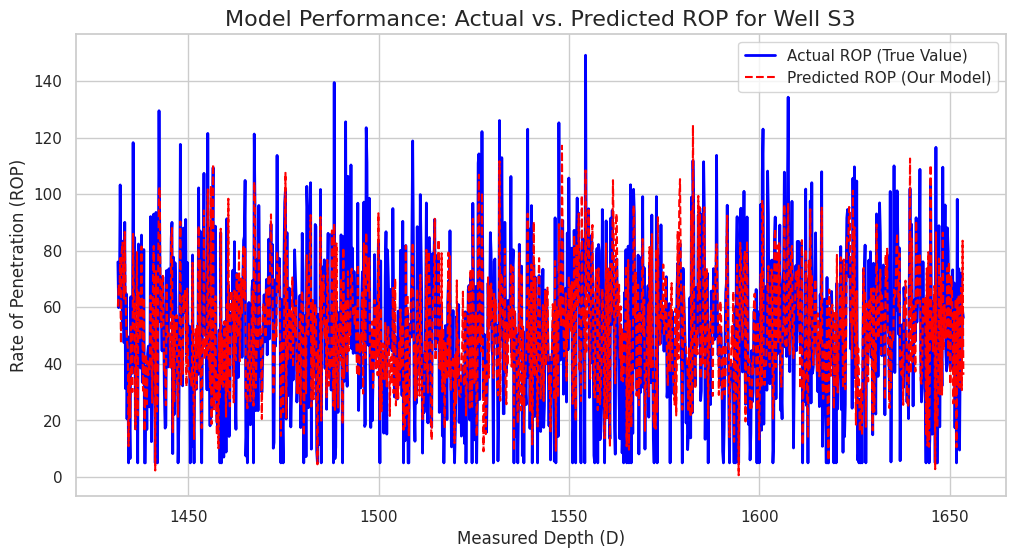

    -> Saved plot to 'S3_rop_comparison_plot.png'
  Generating plot for Well: S2...


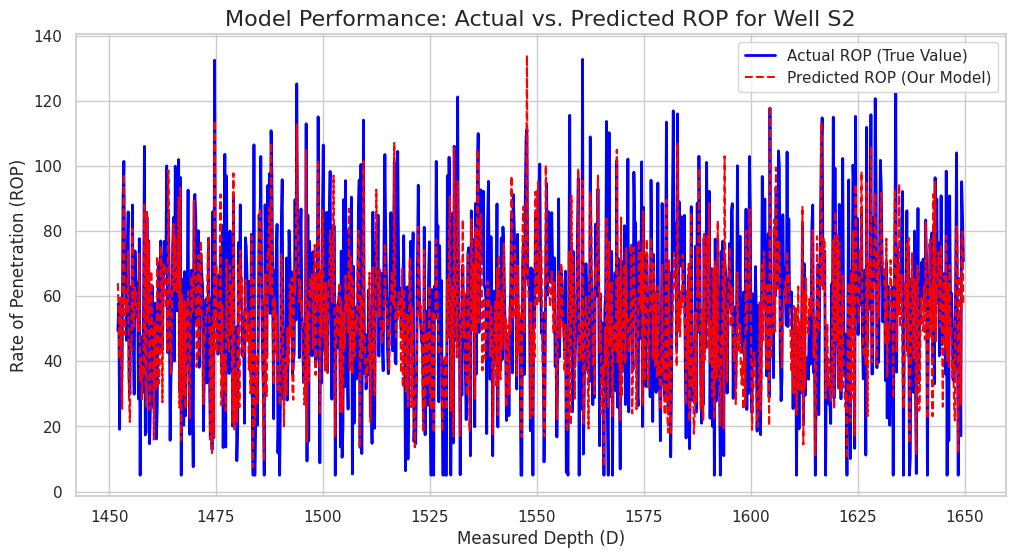

    -> Saved plot to 'S2_rop_comparison_plot.png'
  Generating plot for Well: S1...


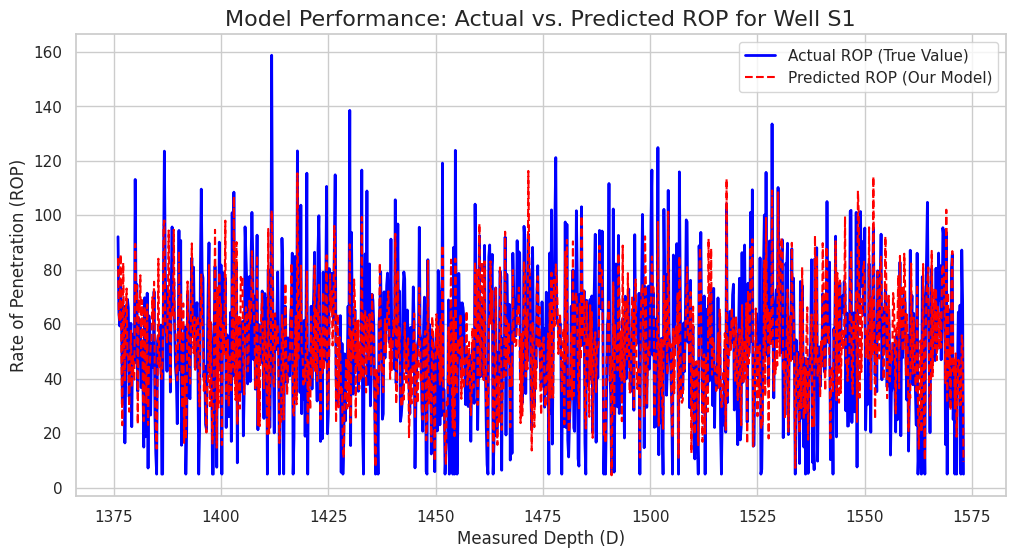

    -> Saved plot to 'S1_rop_comparison_plot.png'

--- All plots generated! ---
You can find the saved .png files in the 'training_and_testing_wells/testing_wells/comparison_plots' folder.


In [8]:
print("Starting Part 7: Visualizing Model Performance...")

# --- 1. CONFIGURATION ---
# Define the paths
parent_dir = "training_and_testing_wells/testing_wells"
comparator_path = os.path.join(parent_dir, "comparator_dataset")
# This is where we will save the new plot images
plots_output_path = os.path.join(parent_dir, "comparison_plots")

# --- 2. CREATE THE OUTPUT DIRECTORY ---
print(f"Creating plots directory (if it doesn't exist): '{plots_output_path}'")
os.makedirs(plots_output_path, exist_ok=True)

# --- 3. FIND ALL "COMPARATOR" FILES ---
comparator_files = glob.glob(os.path.join(comparator_path, "*_comparator.csv"))

if not comparator_files:
    print(f"--- ERROR ---")
    print(f"Could not find any '_comparator.csv' files in '{comparator_path}'")
else:
    print(f"\nFound {len(comparator_files)} comparator files to plot...")

    # --- 4. LOOP, LOAD, AND PLOT EACH FILE ---
    for comp_file_path in comparator_files:
        try:
            comp_filename = os.path.basename(comp_file_path)

            # Get the well key, e.g., "S2_comparator.csv" -> "S2"
            well_key = comp_filename.split('_')[0]

            print(f"  Generating plot for Well: {well_key}...")

            # Load the comparator dataset
            df_comp = pd.read_csv(comp_file_path)

            # --- !! This is the plotting magic !! ---

            # A) Create a new, blank "figure" (our canvas)
            # We make it 12 inches wide by 6 inches tall for a nice view
            plt.figure(figsize=(12, 6))

            # B) Plot the "Actual" ROP
            # We plot 'D' (Depth) on the x-axis and 'rop_avg' on the y-axis
            plt.plot(
                df_comp['D'],
                df_comp['rop_avg'],
                label='Actual ROP (True Value)',  # This name will show up in the legend
                color='blue',                    # Make this line blue
                linewidth=2                      # Make it a bit thicker
            )

            # C) Plot the "Predicted" ROP on the *same chart*
            # We plot 'D' (Depth) on the x-axis and 'rop_avg_prediction' on the y-axis
            plt.plot(
                df_comp['D'],
                df_comp['rop_avg_prediction'],
                label='Predicted ROP (Our Model)', # This name will also be in the legend
                color='red',                       # Make this line red
                linestyle='--'                     # Make it a dashed line to tell it apart
            )

            # D) Add labels and a title to make it professional
            plt.title(f'Model Performance: Actual vs. Predicted ROP for Well {well_key}', fontsize=16)
            plt.xlabel('Measured Depth (D)', fontsize=12)
            plt.ylabel('Rate of Penetration (ROP)', fontsize=12)

            # E) Add a legend and a grid
            plt.legend()  # This adds the little box with "Actual" and "Predicted" labels
            plt.grid(True)  # Adds a faint grid to make it easier to read

            # F) Save the plot to a file
            output_plot_name = f"{well_key}_rop_comparison_plot.png"
            output_plot_path = os.path.join(plots_output_path, output_plot_name)
            plt.savefig(output_plot_path)

            # G) Show the plot right here in the notebook!
            plt.show()

            # H) Close the plot so the next loop starts fresh
            plt.close()

            print(f"    -> Saved plot to '{output_plot_name}'")

        except Exception as e:
            print(f"--- ERROR plotting file {comp_filename}: {e} ---")

    print("\n--- All plots generated! ---")
    print(f"You can find the saved .png files in the '{plots_output_path}' folder.")

(averaged curve)

Starting Part 7: Visualizing Model Performance (with SMOOTHING!)...
Creating plots directory (if it doesn't exist): 'training_and_testing_wells/testing_wells/comparison_plots'

Found 3 comparator files to plot...
  Generating plot for Well: S3...
    -> Applying 15-point rolling average to smooth the data...


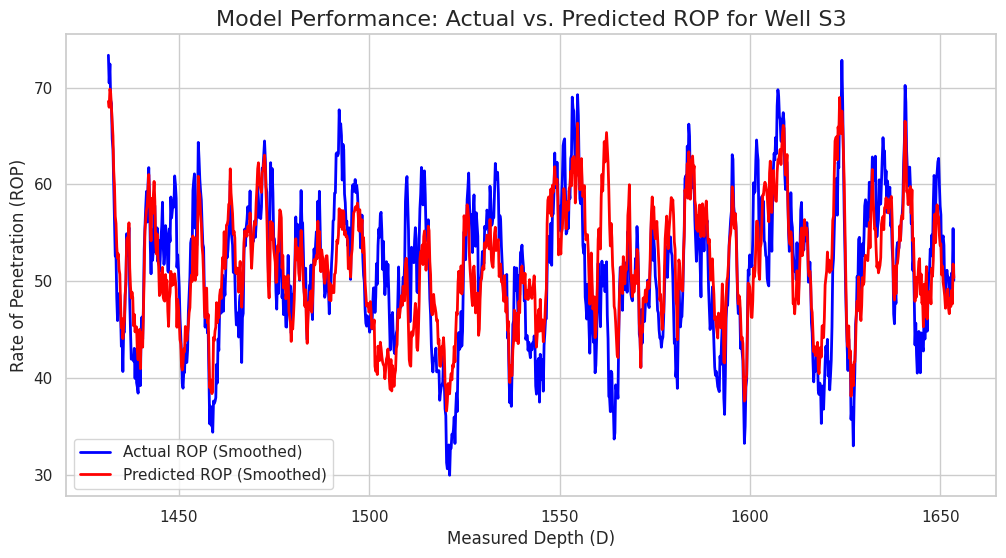

    -> Saved smooth plot to 'S3_rop_comparison_plot_SMOOTH.png'
  Generating plot for Well: S2...
    -> Applying 15-point rolling average to smooth the data...


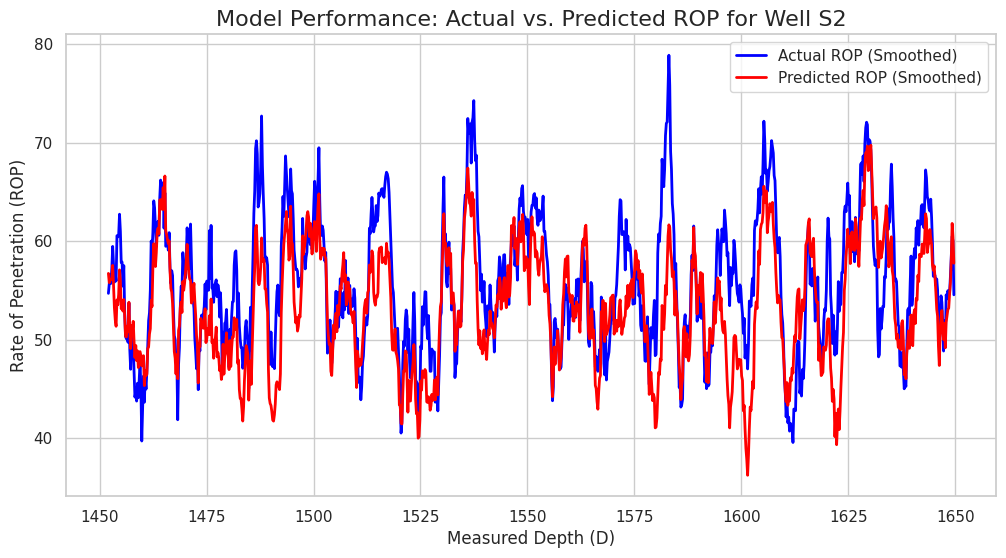

    -> Saved smooth plot to 'S2_rop_comparison_plot_SMOOTH.png'
  Generating plot for Well: S1...
    -> Applying 15-point rolling average to smooth the data...


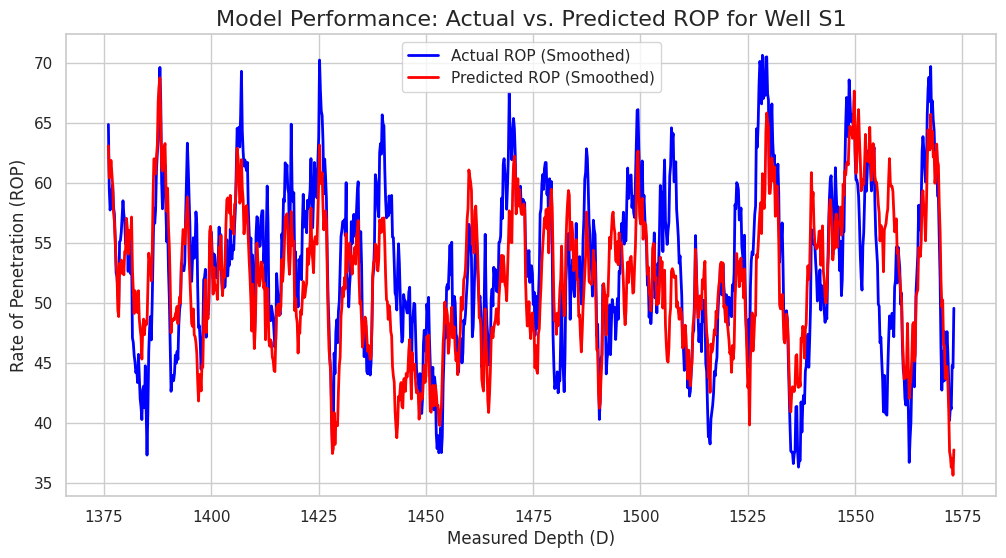

    -> Saved smooth plot to 'S1_rop_comparison_plot_SMOOTH.png'

--- All plots generated! ---


In [9]:
print("Starting Part 7: Visualizing Model Performance (with SMOOTHING!)...")

# --- 1. CONFIGURATION ---
parent_dir = "training_and_testing_wells/testing_wells"
comparator_path = os.path.join(parent_dir, "comparator_dataset")
plots_output_path = os.path.join(parent_dir, "comparison_plots")

# --- !! NEW SETTING !! ---
# This is our "smoothing" factor.
# It will average every 15 points.
# Try 10, 20, or 30 to see what looks best!
ROLLING_WINDOW_SIZE = 15

# --- 2. CREATE THE OUTPUT DIRECTORY ---
print(f"Creating plots directory (if it doesn't exist): '{plots_output_path}'")
os.makedirs(plots_output_path, exist_ok=True)

# --- 3. FIND ALL "COMPARATOR" FILES ---
comparator_files = glob.glob(os.path.join(comparator_path, "*_comparator.csv"))

if not comparator_files:
    print(f"--- ERROR ---")
    print(f"Could not find any '_comparator.csv' files in '{comparator_path}'")
else:
    print(f"\nFound {len(comparator_files)} comparator files to plot...")

    # --- 4. LOOP, LOAD, SMOOTH, AND PLOT EACH FILE ---
    for comp_file_path in comparator_files:
        try:
            comp_filename = os.path.basename(comp_file_path)
            well_key = comp_filename.split('_')[0]
            print(f"  Generating plot for Well: {well_key}...")

            df_comp = pd.read_csv(comp_file_path)

            # --- !! THIS IS THE NEW SMOOTHING STEP !! ---
            print(f"    -> Applying {ROLLING_WINDOW_SIZE}-point rolling average to smooth the data...")

            # This calculates the moving average for both columns
            df_comp['rop_avg_smoothed'] = df_comp['rop_avg'].rolling(
                window=ROLLING_WINDOW_SIZE,
                center=True, # 'center=True' makes the average look better
                min_periods=1 # This handles the edges gracefully
            ).mean()

            df_comp['rop_pred_smoothed'] = df_comp['rop_avg_prediction'].rolling(
                window=ROLLING_WINDOW_SIZE,
                center=True,
                min_periods=1
            ).mean()
            # --------------------------------------------------


            # --- Plotting Code (now uses the _smoothed columns) ---

            plt.figure(figsize=(12, 6))

            # B) Plot the SMOOTHED Actual ROP
            plt.plot(
                df_comp['D'],
                df_comp['rop_avg_smoothed'],  # <-- Use the new smoothed column
                label='Actual ROP (Smoothed)',
                color='blue',
                linewidth=2
            )

            # C) Plot the SMOOTHED Predicted ROP
            plt.plot(
                df_comp['D'],
                df_comp['rop_pred_smoothed'], # <-- Use the new smoothed column
                label='Predicted ROP (Smoothed)',
                color='red',
                linewidth=2
            )

            # D) Add labels and a title
            plt.title(f'Model Performance: Actual vs. Predicted ROP for Well {well_key}', fontsize=16)
            plt.xlabel('Measured Depth (D)', fontsize=12)
            plt.ylabel('Rate of Penetration (ROP)', fontsize=12)

            # E) Add a legend and a grid
            plt.legend()
            plt.grid(True)

            # F) Save the plot to a file
            output_plot_name = f"{well_key}_rop_comparison_plot_SMOOTH.png"
            output_plot_path = os.path.join(plots_output_path, output_plot_name)
            plt.savefig(output_plot_path)

            # G) Show the plot right here in the notebook!
            plt.show()

            # H) Close the plot
            plt.close()

            print(f"    -> Saved smooth plot to '{output_plot_name}'")

        except Exception as e:
            print(f"--- ERROR plotting file {comp_filename}: {e} ---")

    print("\n--- All plots generated! ---")